In [1]:
# Simulating dynamics of Argon atoms
# Starting with outlining general kinematics of particles

(1/3) Weekly tasks:

1) Incorporate **density** and **temperature** into simulation. These are part of the initial conditions. Set up a lattice of 3x3x3 unit cells, where each cells can have 4 particles. The size of the unit cell $a$ determines the density. Use the Maxwell distribution to relate the velocity of the particles to the temperature. **Make sure it's dimensionless!** Now the kinetic energy is $KE=(N-1)\frac{3}{2}k_BT$. The KE & PE will not be stable, so scale the velocity by a factor of $\lambda$ such that $v_i\rightarrow \lambda v_i$, $\lambda = \sqrt{\frac{(N-1)3k_BT}{\sum_i mv_i^2}}$. This is to keep a constant temperature.

2) Observables, including: (1) **pair correlation function** (_15%_). A histogram of the number of particles $n(r)$ at a distance $[r, r+\Delta r]$ for bin size $\Delta r$ which is smaller than $L/2$. The distribution of $N$ particles in a volume $V$ is $g(r)=\frac{2V}{N(N-1)}\frac{\langle n(r)\rangle}{4\pi r^2 \Delta r}$. And (2) the **pressure** (_15%_) or **specific heat** (_If in addition to pressure, up to 10% bonus_). These are given as $\frac{\beta P}{\rho} = 1-\frac{\beta}{3N}\Big\langle \frac{1}{2}\sum_{i,j}\vec{r}_{ij}\frac{\partial U}{\partial \vec {r}_{ij}}\Big\rangle$ where $\beta = \frac{1}{k_BT}$. The specific heat is given as $\frac{\langle \delta K^2\rangle}{\langle K\rangle ^2} = \frac{2}{3N}\Big(1-\frac{3N}{2C_V}\Big)$ where $\langle\delta K^2\rangle = \langle K^2\rangle - \langle K\rangle ^2$, the fluctuation in kinetic energy.

3) Error: For observables, use (block) bootstrap method, with consideration to the correlation of the observables. Given an original set x, create a set of random elements from x(original) where elements can be repeated. This new dataset is 1 bootstrap subset, x$_1^*$. You can take the mean, A$_1^*$, of each bootstrap subset. In total we say we have M number of bootstrap subsets, and M number of means. We take the "mean of the means", $\mu^* = \frac{1}{M}\sum_{i=1}^{M}A_i^*$. The boostrap variance is $s_i^* = A_i^{*2} - \mu^{*2}$. In general, set M=100. Include the standard deviation f the observables as the errorbars for plots.

Things to do towards the end:
- Write up a report
- Polish comments -- get rid of commented code that isn't useful, and only comment "nontrivial" sections

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u

import Functions as func

Parameters for states of matter:

Gas: $\rho=0.3$, $T=3$

Liquid: $\rho=0.8$, $T=1$

Solid: $\rho=1.2$, $T=0.5$

In [3]:
# The force at x is the negative gradient of the potential at x
# The gradient of the potential is the derivative of the potential WRT r times x/r
# where r is the magnitude of the distance and x is a vector

# Initial conditions
T = 3
rho = 0.3
h = 0.05                                   # time step
num_time = 40                              # number of time steps
num_unit_cells_per_dim = 3                 # number of particles in each direction
num_unit_cells = num_unit_cells_per_dim**3 # total number of particles
num_part = 4 * num_unit_cells
L = np.power(num_part / rho, 1/3.0)        # size of unit cell

Rachel: I'd like to go over the cell above here. There are only 2 initial coordinates? What is the difference between "num_part_per_dim" and "num_part"? If there are four particles, what are the coordinates?

In [4]:
# state consists of 6 degrees of freedom: 3 position coordinates, 3 velocities
state = np.zeros((num_part, num_time, 6))

# store the kinetic and potential energy of 2 particles in 3 dimensions for num_time timesteps
E_kin = np.zeros((num_part, num_time))
E_pot = np.zeros((num_part, num_time))
E_tot = np.zeros((num_part, num_time))

# calculate the initial coordinates by placing all particles on a fcc lattice
# the initial velocities of the particles are given by a gaussian ditribution
unit_cell = 0
mu = 1
sigma = np.sqrt(T)
rescaling_time = 20

# create distribution of e^(-mv^2 / 2k_B * T), where k_B = 1 and m = 1
velocity_distribution = np.random.normal(mu, sigma, num_part)

for x in range(num_unit_cells_per_dim):
    for y in range(num_unit_cells_per_dim):
        for z in range(num_unit_cells_per_dim):
            cell_offset = np.asarray([x, y, z]) * L
            state[unit_cell + 0, 0, :3] = np.asarray([0.0, 0.0, 0.0]) + cell_offset
            state[unit_cell + 1, 0, :3] = np.asarray([L / 2.0, L / 2.0, 0.0]) + cell_offset
            state[unit_cell + 2, 0, :3] = np.asarray([L / 2.0, 0.0, L / 2.0]) + cell_offset
            state[unit_cell + 3, 0, :3] = np.asarray([L / 2.0, L / 2.0, L / 2.0]) + cell_offset

            state[unit_cell + 0, 0, 3:] = velocity_distribution[unit_cell + 0] * func.create_random_vector()
            state[unit_cell + 1, 0, 3:] = velocity_distribution[unit_cell + 1] * func.create_random_vector()

            unit_cell += 4

# store initial kinetic, potential and total energy of each particle and the system
for i in range(num_part):
    E_kin[i, 0] = func.norm(func.KE(state[i, 0, 3:]))
    E_pot[i, 0] = 0
    E_tot[i, 0] += E_pot[i, 0] + E_kin[i, 0]
    
# Save distances between reference particle and others for pair correlation function
distances = np.zeros((num_time, num_part-1))
# Initial distances
for i in range(1, num_part):
    distances[0, i-1] = func.dist(state[0,0,:3], state[i,0,:3])

Rachel: I don't understand np.tile and np.repeat. I think there might be some confusion between initial_coords, num_part, and num_part_per_dim. 

In [5]:
# Change in position and velocity
for t in range(1, num_time):    
    for i in range(1, num_part):        
        if t == rescaling_time:
            func.rescale_velocities(state, t-1, num_part, T)
        
        # the distance and force between the two closest particles at t-1
        r = func.get_r(state, t-1, i, L)
        F = func.acceleration(r)

        # positions at time t
        state[i, t, :3] = func.next_position(state[i, t-1, :3], state[i, t-1, 3:], F, h, L)

        # r, force and velocity at time t
        r_next = func.get_r(state, t, i, L)
        F_next = func.acceleration(r_next)
        v_next = func.next_velocity(state[i, t-1, 3:], F, F_next, h)
        state[i, t, 3:] = v_next

        # calculate the energy of the particle
        E_kin[i, t] = func.norm(func.KE(v_next))
        E_pot[i, t] = func.LJP(func.norm(r_next))
        E_tot[i, t] += E_pot[i, t] + E_kin[i, t]

/home/daniel/study/comp_physics/Project1/Functions.py:89: RuntimeWarning: overflow encountered in square
  return 0.5 * v**2.
/home/daniel/study/comp_physics/Project1/Functions.py:11: RuntimeWarning: overflow encountered in square
  return np.sqrt(np.sum(r**2., axis))
/home/daniel/study/comp_physics/Project1/Functions.py:54: RuntimeWarning: overflow encountered in double_scalars
  return -48./(r**13.) + 24./(r**7.)
/home/daniel/study/comp_physics/Project1/Functions.py:96: RuntimeWarning: overflow encountered in double_scalars
  return 4.*(1./(r**12.) - 1./(r**6))
/home/daniel/study/comp_physics/Project1/Functions.py:54: RuntimeWarning: divide by zero encountered in double_scalars
  return -48./(r**13.) + 24./(r**7.)
/home/daniel/study/comp_physics/Project1/Functions.py:54: RuntimeWarning: invalid value encountered in double_scalars
  return -48./(r**13.) + 24./(r**7.)
/home/daniel/study/comp_physics/Project1/Functions.py:96: RuntimeWarning: divide by zero encountered in double_scalars


For pair correlation function: Count the number of particles at a given distance within a bin size (have the bin size variable). Take the average of this count over all time steps. This will be "_n(r)_"

In [6]:
binsize = 0.005
binnum = L/binsize
binnum = int(binnum)
np.histogram(distances[0], bins=100, range=(0, L))[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3])

man this is a mess

https://en.wikipedia.org/wiki/Radial_distribution_function
https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram.html
https://gitlab.kwant-project.org/computational_physics_19/course_notes/blob/master/project%201/project.md

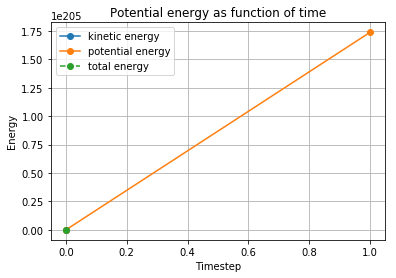

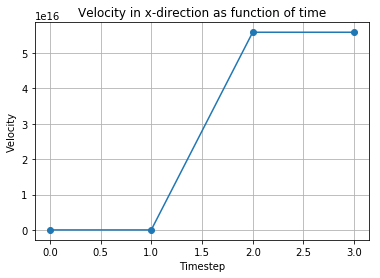

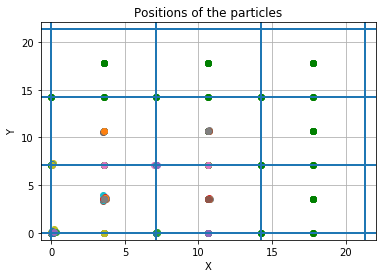

In [7]:
# plot the potential, kinetic and total energy
plt.title('Potential energy as function of time')
plt.plot(range(num_time), np.sum(E_kin[:, :], axis=0), linestyle='-', marker='o', label='kinetic energy')
plt.plot(range(num_time), np.sum(E_pot[:, :], axis=0), linestyle='-', marker='o', label='potential energy')    
plt.plot(range(num_time), np.sum(E_tot[:, :], axis=0), linestyle='--', marker='o', label='total energy')
plt.xlabel('Timestep')
plt.ylabel('Energy')
plt.grid()
plt.legend()
plt.figure()

# plot the velocity in x-direction
plt.title('Velocity in x-direction as function of time')
plt.plot(range(num_time), state[1, :, 3], linestyle='-', marker='o', label='velocity')
plt.xlabel('Timestep')
plt.ylabel('Velocity')
plt.grid()

# plot the positions of all particles in a new figure and plot the initial positions in green
plt.figure()
plt.title('Positions of the particles')
for x in range(num_part):
    plt.scatter(state[x, 1:, 0], state[x, 1:, 1], label='particle {}'.format(x))
    plt.scatter(state[x, 0, 0], state[x, 0, 1], c='g')

# restrict the view around the box + a small margin
view_margin = L / 10.0
plt.xlim(-view_margin, L * num_unit_cells_per_dim + view_margin)
plt.ylim(-view_margin, L * num_unit_cells_per_dim + view_margin)
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()

# add border lines around the box
for x in range(num_unit_cells_per_dim + 1):
    for y in range(num_unit_cells_per_dim + 1):
        plt.axvline(x * L)
        plt.axhline(y * L)

plt.show()

The simulation works (I think), because:
- The 3 particles move towards the particle in the center in the beginning
- At a certain point, the repulsive term dominates the attractive term, which causes the three particles to move away from the center again. This term is stonger and therefore has more effect on the velocities. At this point the sign of the velocity changes and there is a stronger potential energy. This causes the particles to oscillate around an equilibrium.
- The potential energy is always negative
- The total energy is conserved throughout time, but not during each oscillation. I don't know whether that should be the case.